# Profile generation

In [20]:
import numpy as np
import pandas as pd

np.random.seed(42)  # For reproducibility

# Define distributions and lookup values for categories
education_levels = ["High School", "Associate's", "Bachelor's", "Master's", "PhD", "Professional (MD/JD)"]
# Probabilities for women's education (summing to 1)
edu_probs_women = [0.10, 0.10, 0.40, 0.25, 0.05, 0.10]
# Probabilities for men's education (slightly different)
edu_probs_men =   [0.12, 0.15, 0.40, 0.20, 0.05, 0.08]

dating_intentions = ["Casual", "Long-term", "Marriage-Oriented", "Open to Either", "Figuring it Out"]
# Probabilities for women intentions
intent_probs_women = [0.15, 0.25, 0.15, 0.25, 0.20]
# Probabilities for men intentions (more casual)
intent_probs_men   = [0.25, 0.20, 0.10, 0.30, 0.15]

drinking_habits = ["Never", "Socially", "Often"]
# Probabilities for drinking habits
drink_probs_women = [0.20, 0.70, 0.10]
drink_probs_men   = [0.15, 0.65, 0.20]

# Personality traits list
personality_traits = [
    "Adventurous", "Ambitious", "Artistic", "Athletic", "Carefree", "Compassionate",
    "Creative", "Easygoing", "Funny", "Intellectual", "Outgoing", "Spontaneous",
    "Down-to-earth", "Energetic", "Thoughtful", "Charming"
]

# Attractiveness descriptors for women (ordered roughly from moderate to high attractiveness)
attract_desc_women = [
    "Cute girl-next-door", "Charming with a warm smile", "Pretty and down-to-earth",
    "Cute and bubbly personality", "Charming and sweet", "Elegant and graceful",
    "Gorgeous and confident", "Stunning and charismatic"
]
# Attractiveness descriptors for men (from lower to higher)
attract_desc_men = [
    "Average-looking guy with a friendly vibe", "Down-to-earth looks, great personality",
    "Cute in a nerdy way", "Boy-next-door charm", "Tall, athletic build, nice smile",
    "Charming and well-groomed", "Rugged and handsome", "Model-like looks"
]

# Assign numeric attractiveness scores (0 to 1) for each person
women_attract_scores = np.clip(np.random.normal(loc=0.5, scale=0.15, size=100), 0, 1)
men_attract_scores = np.random.beta(a=1.0, b=4.0, size=100)
men_attract_scores = np.clip(men_attract_scores, 0, 1)

def get_attractiveness_description(score, descriptors_list):
    n = len(descriptors_list)
    rank = int(score * n)
    if rank >= n:
        rank = n - 1
    return descriptors_list[rank]

# Generate women's profiles
women_profiles = []
for i in range(100):
    age = int(np.round(np.random.normal(loc=27.0, scale=1.5)))
    age = np.clip(age, 25, 30)
    height = np.random.normal(loc=65.0, scale=2.5)
    height = np.clip(height, 60, 72)
    height = round(height, 1)
    education = np.random.choice(education_levels, p=edu_probs_women)
    intention = np.random.choice(dating_intentions, p=intent_probs_women)
    drinking = np.random.choice(drinking_habits, p=drink_probs_women)
    traits = np.random.choice(personality_traits, size=2, replace=False)
    personality = traits[0] + " and " + traits[1]
    attract_score = women_attract_scores[i]
    attract_desc = get_attractiveness_description(attract_score, attract_desc_women)
    women_profiles.append({
        "WomanID": f"W{i+1}",
        "Age": age,
        "Height(inches)": height,
        "Education": education,
        "Dating Intentions": intention,
        "Drinking Habits": drinking,
        "Personality Traits": personality,
        "Physical Attractiveness": attract_desc
    })

women_df = pd.DataFrame(women_profiles)
women_df.to_csv("synthetic_women_profiles.csv", index=False)
print("Women profiles CSV created.")

# Generate men's profiles
men_profiles = []
for j in range(100):
    age = int(np.round(np.random.normal(loc=27.0, scale=1.5)))
    age = np.clip(age, 25, 30)
    height = np.random.normal(loc=70.0, scale=2.5)
    height = np.clip(height, 64, 78)
    height = round(height, 1)
    education = np.random.choice(education_levels, p=edu_probs_men)
    intention = np.random.choice(dating_intentions, p=intent_probs_men)
    drinking = np.random.choice(drinking_habits, p=drink_probs_men)
    traits = np.random.choice(personality_traits, size=2, replace=False)
    personality = traits[0] + " and " + traits[1]
    attract_score = men_attract_scores[j]
    attract_desc = get_attractiveness_description(attract_score, attract_desc_men)
    men_profiles.append({
        "ManID": f"M{j+1}",
        "Age": age,
        "Height(inches)": height,
        "Education": education,
        "Dating Intentions": intention,
        "Drinking Habits": drinking,
        "Personality Traits": personality,
        "Physical Attractiveness": attract_desc
    })

men_df = pd.DataFrame(men_profiles)
men_df.to_csv("synthetic_men_profiles.csv", index=False)
print("Men profiles CSV crated.")

# Mapping for education levels (for compatibility checks)
edu_level_index = {level: idx for idx, level in enumerate(education_levels)}

# Utility: seriousness level for intentions
intent_rank = {
    "Casual": 1,
    "Figuring it Out": 2,
    "Open to Either": 2,
    "Long-term": 3,
    "Marriage-Oriented": 4
}

# Initialize probability matrices
prob_women_likes_men = np.zeros((100, 100))
prob_men_likes_women = np.zeros((100, 100))

# Calculate Women -> Men probabilities with stronger incompatibility responses
for i, woman in enumerate(women_profiles):
    woman_attr = women_attract_scores[i]
    for j, man in enumerate(men_profiles):
        
        p = 0.6*(0.5/woman_attr)**1
    
        # probability influenced by man's attractiveness
        man_attr = men_attract_scores[j]
        p *= p * man_attr  # unchanged baseline

        # Height compatibility: if man is shorter than woman, apply a stronger penalty.
        if man["Height(inches)"] < woman["Height(inches)"]:
            height_diff = woman["Height(inches)"] - man["Height(inches)"]
            # Increase penalty: 10% per inch difference, up to 40%
            penalty = 1 - min(0.10 * height_diff, 0.40)
            p *= penalty

        # Education compatibility: stronger penalties for education mismatches.
        woman_edu_level = edu_level_index[woman["Education"]]
        man_edu_level = edu_level_index[man["Education"]]
        edu_diff = woman_edu_level - man_edu_level
        if edu_diff >= 2:
            p *= 0.3  # larger penalty for a two-level gap
        elif edu_diff == 1:
            p *= 0.6  # penalty for a one-level gap

        # Dating intentions: stronger penalty for mismatches.
        w_intent = woman["Dating Intentions"]
        m_intent = man["Dating Intentions"]
        if w_intent == m_intent:
            p *= 1.1  # slight boost for matching
        else:
            # If woman is serious and man is casual:
            if (w_intent in ["Long-term", "Marriage-Oriented"]) and m_intent == "Casual":
                p *= 0.3
            # If man is serious and woman is casual:
            elif (m_intent in ["Long-term", "Marriage-Oriented"]) and w_intent == "Casual":
                p *= 0.5
            # If one is serious and the other is "Figuring it Out":
            if (w_intent in ["Long-term", "Marriage-Oriented"]) and m_intent == "Figuring it Out":
                p *= 0.7
            elif (m_intent in ["Long-term", "Marriage-Oriented"]) and w_intent == "Figuring it Out":
                p *= 0.8

        # Drinking compatibility: stronger penalty for a major mismatch.
        w_drink = woman["Drinking Habits"]
        m_drink = man["Drinking Habits"]
        drink_scale = {"Never": 0, "Socially": 1, "Often": 2}
        drink_diff = abs(drink_scale[w_drink] - drink_scale[m_drink])
        if drink_diff == 2:
            p *= 0.8  # stronger penalty

        # Clamp p between 0 and 1.
        p = max(0.0, min(1.0, p))
        prob_women_likes_men[i, j] = p

# Scale the Women->Men matrix to target an average of ~12%
avg_prob_women = prob_women_likes_men.mean()
if avg_prob_women < 0.10 or avg_prob_women > 0.15:
    scale_factor = 0.12 / avg_prob_women
    prob_women_likes_men *= scale_factor
    prob_women_likes_men = np.clip(prob_women_likes_men, 0, 1)

# Calculate Men -> Women probabilities with stronger incompatibility responses
for j, man in enumerate(men_profiles):
    man_attr = men_attract_scores[j]
    for i, woman in enumerate(women_profiles):
        woman_attr = women_attract_scores[i]
        p = 0.15 + 0.5 * woman_attr * (1/man_attr)**0.5 # baseline

        # Height: if woman is taller than man, apply a stronger penalty.
        if woman["Height(inches)"] > man["Height(inches)"]:
            p *= 0.90  # increased penalty from 0.95 to 0.90

        # Dating intentions: stronger penalty for mismatches.
        w_intent = woman["Dating Intentions"]
        m_intent = man["Dating Intentions"]
        if w_intent == m_intent:
            p *= 1.05
        else:
            if (w_intent in ["Long-term", "Marriage-Oriented"]) and m_intent == "Casual":
                p *= 0.6  # stronger penalty than before
            elif (m_intent in ["Long-term", "Marriage-Oriented"]) and w_intent == "Casual":
                p *= 0.8  # stronger penalty than before

        # Drinking compatibility: stronger penalty for major mismatch.
        w_drink = woman["Drinking Habits"]
        m_drink = man["Drinking Habits"]
        drink_diff = abs(drink_scale[w_drink] - drink_scale[m_drink])
        if drink_diff == 2:
            p *= 0.90  # stronger penalty

        p = max(0.0, min(1.0, p))
        prob_men_likes_women[j, i] = p

# Scale the Men->Women matrix to target an average of ~43%
avg_prob_men = prob_men_likes_women.mean()
if avg_prob_men < 0.40 or avg_prob_men > 0.45:
    scale_factor = 0.43 / avg_prob_men
    prob_men_likes_women *= scale_factor
    prob_men_likes_women = np.clip(prob_men_likes_women, 0, 1)

# Create DataFrames for the matrices and save to CSV files.
women_ids = [f"W{k+1}" for k in range(100)]
men_ids   = [f"M{k+1}" for k in range(100)]

wm_df = pd.DataFrame(prob_women_likes_men, index=women_ids, columns=men_ids)
wm_df.to_csv("probability_matrix_women_likes_men.csv", index_label="Woman")
print("Created CSV file for prob women likes men.")

mw_df = pd.DataFrame(prob_men_likes_women, index=men_ids, columns=women_ids)
mw_df.to_csv("probability_matrix_men_likes_women.csv", index_label="Man")
print("Created CSV file for prob men likes women.")

Women profiles CSV created.
Men profiles CSV crated.
Created CSV file for prob women likes men.
Created CSV file for prob men likes women.


# "Tinder-like" simulation

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
import openpyxl  # for Excel export

##############################################################################
# 1) PRELOAD THE CSVs (PROFILES & PROBABILITY MATRICES)
##############################################################################
women_df = pd.read_csv("synthetic_women_profiles.csv")
men_df   = pd.read_csv("synthetic_men_profiles.csv")

prob_women_likes_men = pd.read_csv("probability_matrix_women_likes_men.csv", index_col=0)
prob_men_likes_women = pd.read_csv("probability_matrix_men_likes_women.csv", index_col=0)

# Create lookup dictionaries for profile info.
women_info = {row["WomanID"]: row for _, row in women_df.iterrows()}
men_info   = {row["ManID"]: row for _, row in men_df.iterrows()}

all_women_ids = list(women_info.keys())
all_men_ids   = list(men_info.keys())
all_user_ids  = all_women_ids + all_men_ids

##############################################################################
# 1.5) SELECT "JACK" AND "JILL" AS MIDDLE-PERFORMING PROFILES
##############################################################################
# For Jack, choose the man whose average probability (from women liking men)
# is closest to the overall average among men.
man_avgs = prob_women_likes_men.mean(axis=0)
overall_man_avg = man_avgs.mean()
jack_id = (man_avgs - overall_man_avg).abs().idxmin()

# For Jill, choose the woman whose average probability (from men liking women)
# is closest to the overall average among women.
woman_avgs = prob_men_likes_women.mean(axis=0)
overall_woman_avg = woman_avgs.mean()
jill_id = (woman_avgs - overall_woman_avg).abs().idxmin()

print(f"Selected Jack: {jack_id}, Selected Jill: {jill_id}")

##############################################################################
# 2) THE UPDATED TINDER-STYLE SIMULATION FUNCTION (COMBINED QUEUE)
##############################################################################
def run_tinder_simulation(
    num_days=3,
    daily_queue_size=5,
    weight_queue_penalty=0.5,    # penalty for candidate's pending like queue
    weight_reciprocal=1.0,       # exponent weight on probability that j likes i
    random_seed=42,
    export_trace=False,
    export_jack_jill_trace=False,
    show_plots=True,
    summary_out=None,
    plot_out=None,
    trace_out=None,
    trace_jj_out=None
):
    """
    Runs a Tinder-style simulation in which, upon logging in,
    each user sees a single combined list of candidates. For each candidate:
    
      - If the candidate is already an incoming like (i.e. they previously liked the user),
        then the candidate’s score is defined as S̃₍ᵢⱼ₎ = Pᵢⱼ.
    
      - Otherwise (a fresh candidate), the score is:
            S₍ᵢⱼ₎ = Pᵢⱼ * 1/(1 + w_queue*Qⱼ) * (Pⱼᵢ)^(w_reciprocal)
        where Qⱼ is the number of pending likes for candidate j.
    
    The top daily_queue_size candidates (by score) are shown and processed.
    
    Extra metrics (unseen and stale likes) and Jack & Jill trace export are also provided.
    """
    # Set seeds for reproducibility.
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # Simulation state dictionaries.
    # For incoming likes, store tuples: (sender, sent_day)
    incoming_likes = {uid: [] for uid in all_user_ids}
    matches = {uid: set() for uid in all_user_ids}
    likes_sent = {uid: set() for uid in all_user_ids}
    daily_logs = []  # list of DataFrames (one per day)
    
    # Loop over simulation days.
    for day in range(1, num_days + 1):
        day_records = []
        login_order = all_user_ids.copy()
        random.shuffle(login_order)
        
        for user in login_order:
            # Determine candidate pool (opposite gender, not already matched).
            if user.startswith("W"):
                candidate_pool = [cid for cid in all_men_ids if cid not in matches[user]]
                get_prob = lambda cand: prob_women_likes_men.loc[user, cand]
                get_reciprocal = lambda cand: prob_men_likes_women.loc[cand, user]
            else:
                candidate_pool = [cid for cid in all_women_ids if cid not in matches[user]]
                get_prob = lambda cand: prob_men_likes_women.loc[user, cand]
                get_reciprocal = lambda cand: prob_women_likes_men.loc[cand, user]
            
            # Build a lookup from candidate -> sent_day for those who already liked user.
            incoming_for_user = {}
            for sender, sent_day in incoming_likes[user]:
                # If multiple incoming likes from the same candidate, take the earliest.
                if sender not in incoming_for_user or sent_day < incoming_for_user[sender]:
                    incoming_for_user[sender] = sent_day
            
            # Build a combined candidate list.
            candidate_info = []
            for cand in candidate_pool:
                if cand in incoming_for_user:
                    # Candidate already liked user: use score = P_ij.
                    score = get_prob(cand)
                    candidate_info.append({
                        "CandidateID": cand,
                        "Score": score,
                        "Source": "incoming",
                        "SentDay": incoming_for_user[cand]
                    })
                else:
                    # Fresh candidate.
                    q = len(incoming_likes[cand])  # pending likes for candidate
                    score = get_prob(cand) * (1/(1 + weight_queue_penalty * q)) * (get_reciprocal(cand) ** weight_reciprocal)
                    candidate_info.append({
                        "CandidateID": cand,
                        "Score": score,
                        "Source": "fresh",
                        "SentDay": day  # fresh likes are sent today
                    })
            
            # Sort the combined list by score (descending) and select top daily_queue_size.
            candidate_info_sorted = sorted(candidate_info, key=lambda x: x["Score"], reverse=True)
            selected_candidates = candidate_info_sorted[:daily_queue_size]
            
            # Process each selected candidate.
            for cand_record in selected_candidates:
                cand = cand_record["CandidateID"]
                source = cand_record["Source"]
                sent_day = cand_record["SentDay"]
                like_prob = get_prob(cand)
                roll = np.random.rand()
                decision = "Pass"
                match_formed = False
                
                if roll < like_prob:
                    decision = "Like"
                    # If candidate has already liked user, a match is formed.
                    if user in likes_sent[cand]:
                        match_formed = True
                        matches[user].add(cand)
                        matches[cand].add(user)
                    else:
                        likes_sent[user].add(cand)
                        # For fresh candidates, add this like to candidate's incoming likes.
                        if source == "fresh":
                            incoming_likes[cand].append((user, day))
                    # If the candidate came from the incoming list, remove that pending like.
                    if source == "incoming":
                        for idx, (s, sd) in enumerate(incoming_likes[user]):
                            if s == cand:
                                del incoming_likes[user][idx]
                                break
                delay = day - sent_day  # 0 if fresh; >0 if pending from an earlier day
                day_records.append({
                    "Day": day,
                    "UserID": user,
                    "CandidateID": cand,
                    "Score": cand_record["Score"],
                    "Source": source,
                    "LikeProbability": like_prob,
                    "RandomRoll": roll,
                    "Decision": decision,
                    "MatchFormed": match_formed,
                    "Delay": delay
                })
        daily_logs.append(pd.DataFrame(day_records))
    
    full_log = pd.concat(daily_logs, ignore_index=True)
    likes_by_men = full_log[(full_log["UserID"].str.startswith("M")) & (full_log["Decision"]=="Like")].shape[0]
    likes_by_women = full_log[(full_log["UserID"].str.startswith("W")) & (full_log["Decision"]=="Like")].shape[0]
    unique_matches = sum(len(matches[uid]) for uid in all_men_ids)
    
    # ----- NEW METRICS: Unseen & Stale Likes -----
    # Unseen likes: still pending in incoming_likes.
    unseen_likes_men = 0
    unseen_likes_women = 0
    for uid in all_user_ids:
        for sender, sent_day in incoming_likes[uid]:
            if sender.startswith("M"):
                unseen_likes_men += 1
            elif sender.startswith("W"):
                unseen_likes_women += 1
                    
    # Processed stale likes: processed incoming likes with delay >= 1.
    processed_stale_men = full_log[
        (full_log["Source"]=="incoming") &
        (full_log["Decision"]=="Like") &
        (full_log["Delay"]>=1) &
        (full_log["CandidateID"].str.startswith("M"))
    ].shape[0]
    processed_stale_women = full_log[
        (full_log["Source"]=="incoming") &
        (full_log["Decision"]=="Like") &
        (full_log["Delay"]>=1) &
        (full_log["CandidateID"].str.startswith("W"))
    ].shape[0]
    
    stale_likes_men = processed_stale_men
    stale_likes_women = processed_stale_women
    total_unseen = unseen_likes_men + unseen_likes_women
    total_stale = stale_likes_men + stale_likes_women
    
    # ----- PREPARE THE SUMMARY HTML -----
    report_html = f"""
    <div style='font-size:14px; line-height:1.5;'>
      <b>=== Tinder-Style Simulation Results (Combined Queue) (Seed={random_seed}) ===</b><br>
      Days: {num_days}, Daily Queue Size: {daily_queue_size}<br>
      <br>
      <b>Total Likes Sent:</b> {likes_by_men + likes_by_women}<br>
       - Likes by men: {likes_by_men}<br>
       - Likes by women: {likes_by_women}<br><br>
      <b>Total Unseen Likes Sent:</b> {total_unseen}<br>
       - Men: {unseen_likes_men}<br>
       - Women: {unseen_likes_women}<br><br>
      <b>Total Stale Likes Sent:</b> {total_stale}<br>
       - Men: {stale_likes_men}<br>
       - Women: {stale_likes_women}<br><br>
      <b>Unique Matches Created: <span style="color:purple;">{unique_matches}</span></b>
    </div>
    """
    if summary_out is not None:
        with summary_out:
            summary_out.clear_output(wait=True)
            display(HTML(report_html))
    
    # ----- UPDATE MATCH DISTRIBUTION PLOTS -----
    if show_plots and plot_out is not None:
        fig, axes = plt.subplots(ncols=2, figsize=(14,5))
        men_matches = sorted([(uid, len(matches[uid])) for uid in all_men_ids], key=lambda x: x[1])
        women_matches = sorted([(uid, len(matches[uid])) for uid in all_women_ids], key=lambda x: x[1])
        
        axes[0].bar(range(len(men_matches)), [x[1] for x in men_matches],
                    color="skyblue", edgecolor="black")
        axes[0].set_title("Men's Match Counts (Sorted)")
        axes[0].set_xlabel("Men (sorted by match count)")
        axes[0].set_ylabel("Number of Matches")
        
        axes[1].bar(range(len(women_matches)), [x[1] for x in women_matches],
                    color="lightpink", edgecolor="black")
        axes[1].set_title("Women's Match Counts (Sorted)")
        axes[1].set_xlabel("Women (sorted by match count)")
        axes[1].set_ylabel("Number of Matches")
        
        plt.tight_layout()
        with plot_out:
            plot_out.clear_output(wait=True)
            display(fig)
        plt.close(fig)
    elif plot_out is not None:
        with plot_out:
            plot_out.clear_output(wait=True)
    
    # ----- EXPORT FULL SIMULATION TRACE -----
    if export_trace and trace_out is not None:
        excel_filename = "tinder_simulation_trace.xlsx"
        with pd.ExcelWriter(excel_filename, engine="openpyxl") as writer:
            for d, df_day in enumerate(daily_logs, start=1):
                df_day.to_excel(writer, sheet_name=f"Day_{d}", index=False)
        with trace_out:
            trace_out.clear_output(wait=True)
            display(HTML(f"<b>Created Excel file '{excel_filename}' with one sheet per day.</b>"))
    elif trace_out is not None:
        with trace_out:
            trace_out.clear_output(wait=True)
    
    # ----- EXPORT JACK & JILL TRACE -----
    if export_jack_jill_trace:
        jack_jill_log = full_log[
            (full_log["UserID"].isin([jack_id, jill_id])) |
            (full_log["CandidateID"].isin([jack_id, jill_id]))
        ].copy()
        jack_jill_log.loc[jack_jill_log["UserID"] == jack_id, "UserID"] = "Jack"
        jack_jill_log.loc[jack_jill_log["UserID"] == jill_id, "UserID"] = "Jill"
        jack_jill_log.loc[jack_jill_log["CandidateID"] == jack_id, "CandidateID"] = "Jack"
        jack_jill_log.loc[jack_jill_log["CandidateID"] == jill_id, "CandidateID"] = "Jill"
    
        jack_likes_sent = full_log[(full_log["UserID"] == jack_id) & (full_log["Decision"] == "Like")].shape[0]
        jack_likes_received = full_log[(full_log["CandidateID"] == jack_id) & (full_log["Decision"] == "Like")].shape[0]
        jack_matches = len(matches[jack_id])
    
        jill_likes_sent = full_log[(full_log["UserID"] == jill_id) & (full_log["Decision"] == "Like")].shape[0]
        jill_likes_received = full_log[(full_log["CandidateID"] == jill_id) & (full_log["Decision"] == "Like")].shape[0]
        jill_matches = len(matches[jill_id])
        
        jack_unseen = 0
        jill_unseen = 0
        for uid in all_user_ids:
            for sender, sent_day in incoming_likes[uid]:
                if sender == jack_id:
                    jack_unseen += 1
                if sender == jill_id:
                    jill_unseen += 1
        
        processed_stale_jack = full_log[
            (full_log["Source"]=="incoming") &
            (full_log["Decision"]=="Like") &
            (full_log["Delay"]>=1) &
            (full_log["CandidateID"] == jack_id)
        ].shape[0]
        processed_stale_jill = full_log[
            (full_log["Source"]=="incoming") &
            (full_log["Decision"]=="Like") &
            (full_log["Delay"]>=1) &
            (full_log["CandidateID"] == jill_id)
        ].shape[0]
        
        jack_stale = processed_stale_jack
        jill_stale = processed_stale_jill
    
        metadata_df = pd.DataFrame({
            "Role":          ["Jack", "Jill"],
            "UserID":        [jack_id, jill_id],
            "LikesSent":     [jack_likes_sent, jill_likes_sent],
            "LikesReceived": [jack_likes_received, jill_likes_received],
            "Matches":       [jack_matches, jill_matches],
            "UnseenLikes":   [jack_unseen, jill_unseen],
            "StaleLikes":    [jack_stale, jill_stale]
        })
    
        excel_filename_jj = "tinder_simulation_jack_jill_trace.xlsx"
        with pd.ExcelWriter(excel_filename_jj, engine="openpyxl") as writer:
            metadata_df.to_excel(writer, sheet_name="Metadata", index=False)
            jack_jill_log.to_excel(writer, sheet_name="Jack_Jill", index=False)
        if trace_jj_out is not None:
            with trace_jj_out:
                trace_jj_out.clear_output(wait=True)
                display(HTML(f"<b>Created Excel file '{excel_filename_jj}' with Jack and Jill trace.</b>"))
    elif trace_jj_out is not None:
        with trace_jj_out:
            trace_jj_out.clear_output(wait=True)

##############################################################################
# 3) INTERACTIVE UI FOR THE TINDER-STYLE SIMULATION
##############################################################################
def interactive_tinder_simulation():
    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='350px')
    
    # Create parameter widgets.
    controls = {
        "num_days": widgets.IntSlider(value=3, min=1, max=7, step=1, description="Days", style=style, layout=layout),
        "daily_queue_size": widgets.IntSlider(value=5, min=3, max=10, step=1, description="Daily Queue Size", style=style, layout=layout),
        "weight_queue_penalty": widgets.FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description="Queue Penalty Weight", style=style, layout=layout),
        "weight_reciprocal": widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description="Reciprocal Weight", style=style, layout=layout),
        "random_seed": widgets.IntSlider(value=42, min=1, max=5000, step=1, description="Random Seed", style=style, layout=layout),
        "export_trace": widgets.Checkbox(value=False, description="Export Excel Trace?", style=style, layout=layout),
        "export_jack_jill_trace": widgets.Checkbox(value=False, description="Export Jack & Jill Trace?", style=style, layout=layout),
        "show_plots": widgets.Checkbox(value=True, description="Show Plots?", style=style, layout=layout)
    }
    
    ui = widgets.VBox(list(controls.values()))
    
    # Create dedicated output widgets.
    summary_out = widgets.Output()
    plot_out = widgets.Output()
    trace_out = widgets.Output()
    trace_jj_out = widgets.Output()
    
    display(ui)
    display(summary_out, plot_out, trace_out, trace_jj_out)
    
    # Wrapper function to include output widgets.
    def run_simulation_wrapper(**kwargs):
        run_tinder_simulation(**kwargs,
                              summary_out=summary_out,
                              plot_out=plot_out,
                              trace_out=trace_out,
                              trace_jj_out=trace_jj_out)
    
    out = widgets.interactive_output(run_simulation_wrapper, controls)
    display(out)

# To run the interactive Tinder-style simulation, simply call:
# interactive_tinder_simulation()

Selected Jack: M75, Selected Jill: W26


In [4]:
interactive_tinder_simulation()

Output()

Output()

Output()

Output()

Output()

# "Hinge-like" simulation

In [13]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, update_display, HTML
import openpyxl  # for Excel export

##############################################################################
# 1) PRELOAD THE CSVs (PROFILES & PROBABILITY MATRICES)
##############################################################################
women_df = pd.read_csv("synthetic_women_profiles.csv")
men_df   = pd.read_csv("synthetic_men_profiles.csv")

prob_women_likes_men = pd.read_csv("probability_matrix_women_likes_men.csv", index_col=0)
prob_men_likes_women = pd.read_csv("probability_matrix_men_likes_women.csv", index_col=0)

# Create lookup dictionaries for profile info.
women_info = {row["WomanID"]: row for _, row in women_df.iterrows()}
men_info   = {row["ManID"]: row for _, row in men_df.iterrows()}

all_women_ids = list(women_info.keys())
all_men_ids   = list(men_info.keys())
all_user_ids  = all_women_ids + all_men_ids

##############################################################################
# 1.5) SELECT "JACK" AND "JILL" AS MIDDLE-PERFORMING PROFILES
##############################################################################
# For Jack, we choose the man whose average probability (from women liking men)
# is closest to the overall average among men.
man_avgs = prob_women_likes_men.mean(axis=0)
overall_man_avg = man_avgs.mean()
jack_id = (man_avgs - overall_man_avg).abs().idxmin()

# For Jill, we choose the woman whose average probability (from men liking women)
# is closest to the overall average among women.
woman_avgs = prob_men_likes_women.mean(axis=0)
overall_woman_avg = woman_avgs.mean()
jill_id = (woman_avgs - overall_woman_avg).abs().idxmin()

print(f"Selected Jack: {jack_id}, Selected Jill: {jill_id}")

##############################################################################
# 2) THE SIMULATION FUNCTION THAT UPDATES PERSISTENT OUTPUT AREAS
##############################################################################
def run_dating_simulation(
    num_days=3,
    daily_queue_size=5,
    incoming_order="FIFO",  # "FIFO" or "LIFO"
    weight_queue_penalty=0.5,       # penalty if candidate's incoming-like queue is long
    weight_reciprocal=1.0,          # weight on probability of j liking i back
    random_seed=42,
    export_trace=False,
    export_jack_jill_trace=False,
    show_plots=True
):
    """
    Runs the Hinge-like dating app simulation (with live, persistent updating).
    The summary text and plots are updated in place using fixed display_ids.
    """
    # Set seeds for reproducibility.
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # ----- Simulation State Dictionaries -----
    # For incoming likes we now store tuples: (sender, day_sent)
    incoming_likes = {uid: [] for uid in all_user_ids}   # pending likes list per user
    matches = {uid: set() for uid in all_user_ids}         # matched partners per user
    likes_sent = {uid: set() for uid in all_user_ids}      # record of who each user liked
    
    daily_logs = []  # list of DataFrames (one per day)
    total_likes_decisions = 0
    
    # Simulation loop.
    for day in range(1, num_days + 1):
        day_records = []
        login_order = all_user_ids.copy()
        random.shuffle(login_order)
        
        for user in login_order:
            # Set candidate pool and probability lookups based on gender.
            if user.startswith("W"):
                candidate_pool = [cid for cid in all_men_ids if cid not in matches[user]]
                get_prob = lambda cand: prob_women_likes_men.loc[user, cand]
                get_reciprocal = lambda cand: prob_men_likes_women.loc[cand, user]
            else:
                candidate_pool = [cid for cid in all_women_ids if cid not in matches[user]]
                get_prob = lambda cand: prob_men_likes_women.loc[user, cand]
                get_reciprocal = lambda cand: prob_women_likes_men.loc[cand, user]
            
            # (a) Build incoming likes portion.
            # Note: incoming_likes now stores (sender, sent_day) tuples.
            user_incoming = incoming_likes[user].copy()
            if incoming_order.upper() == "LIFO":
                user_incoming = list(reversed(user_incoming))
            num_incoming = min(len(user_incoming), daily_queue_size)
            incoming_queue = user_incoming[:num_incoming]
            incoming_likes[user] = user_incoming[num_incoming:]
            
            # For fresh recommendations, remove any candidate already in the incoming queue.
            incoming_ids = [sender for (sender, _) in incoming_queue]
            candidate_pool = [cid for cid in candidate_pool if cid not in incoming_ids]
            
            # (b) Build fresh recommendations using the new scoring formula:
            # S_ij = P_ij * 1/(1+w_queue*Q_j) * (P_ji)^(w_reciprocal)
            num_fresh = daily_queue_size - num_incoming
            rec_scores = {}
            for cand in candidate_pool:
                base_prob = get_prob(cand)  # P_ij
                score = base_prob
                q = len(incoming_likes[cand])
                score *= 1 / (1 + weight_queue_penalty * q)
                reciprocal_prob = get_reciprocal(cand)
                score *= (reciprocal_prob ** weight_reciprocal)
                rec_scores[cand] = score
            if num_fresh > 0 and rec_scores:
                sorted_candidates = sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)
                fresh_candidates = [cand for cand, _ in sorted_candidates[:num_fresh]]
            else:
                fresh_candidates = []
            
            # (c) Form daily queue.
            # For incoming likes, we already have the (sender, sent_day) tuple.
            # For fresh candidates, treat them as if the like is being sent today.
            daily_queue = ([(sender, "incoming", sent_day) for (sender, sent_day) in incoming_queue] + 
                           [(cid, "fresh", day) for cid in fresh_candidates])
            
            # (d) Process queue.
            for candidate, source, sent_day in daily_queue:
                if candidate in matches[user]:
                    continue
                like_prob = get_prob(candidate)
                roll = np.random.rand()
                decision = "Pass"
                match_formed = False
                if roll < like_prob:
                    decision = "Like"
                    total_likes_decisions += 1
                    # For incoming likes, candidate had already sent a like to user.
                    if user in likes_sent[candidate]:
                        match_formed = True
                        matches[user].add(candidate)
                        matches[candidate].add(user)
                    else:
                        likes_sent[user].add(candidate)
                        # Only fresh likes get added to the recipient's incoming queue (with today's timestamp).
                        if source == "fresh":
                            incoming_likes[candidate].append((user, day))
                delay = day - sent_day  # delay is 0 for fresh likes; >0 for likes pending from an earlier day.
                day_records.append({
                    "Day": day,
                    "UserID": user,
                    "CandidateID": candidate,
                    "QueueType": source,
                    "LikeProbability": like_prob,
                    "RandomRoll": roll,
                    "Decision": decision,
                    "MatchFormed": match_formed,
                    "Delay": delay
                })
        daily_logs.append(pd.DataFrame(day_records))
    
    full_log = pd.concat(daily_logs, ignore_index=True)
    likes_by_men = full_log[(full_log["UserID"].str.startswith("M")) & (full_log["Decision"]=="Like")].shape[0]
    likes_by_women = full_log[(full_log["UserID"].str.startswith("W")) & (full_log["Decision"]=="Like")].shape[0]
    unique_matches = sum(len(matches[uid]) for uid in all_men_ids)
    
    # ----- NEW METRICS: Unseen & Stale Likes -----
    # Unseen likes: pending in incoming_likes (each entry is a tuple (sender, sent_day))
    unseen_likes_men = 0
    unseen_likes_women = 0
    for uid in all_user_ids:
        for sender, sent_day in incoming_likes[uid]:
            if sender.startswith("M"):
                unseen_likes_men += 1
            elif sender.startswith("W"):
                unseen_likes_women += 1
                    
    # Processed stale likes: likes from the incoming queue that were seen with a delay >= 1 day.
    processed_stale_men = full_log[
        (full_log["QueueType"]=="incoming") & 
        (full_log["Decision"]=="Like") & 
        (full_log["Delay"]>=1) & 
        (full_log["CandidateID"].str.startswith("M"))
    ].shape[0]
    processed_stale_women = full_log[
        (full_log["QueueType"]=="incoming") & 
        (full_log["Decision"]=="Like") & 
        (full_log["Delay"]>=1) & 
        (full_log["CandidateID"].str.startswith("W"))
    ].shape[0]
    
    # Now, stale likes are defined only from processed likes (not including unseen ones).
    stale_likes_men = processed_stale_men
    stale_likes_women = processed_stale_women
    
    total_unseen = unseen_likes_men + unseen_likes_women
    total_stale = stale_likes_men + stale_likes_women
    
    # Prepare the summary HTML with new top-line totals.
    report_html = f"""
    <div style='font-size:14px; line-height:1.5;'>
      <b>=== Simulation Results (Seed={random_seed}) ===</b><br>
      Days: {num_days}, Daily Queue Size: {daily_queue_size}<br>
      Incoming Order: {incoming_order}<br>
      <br>
      <b>Total Likes Sent:</b> {likes_by_men + likes_by_women}<br>
       - Likes by men: {likes_by_men}<br>
       - Likes by women: {likes_by_women}<br><br>
      <b>Total Unseen Likes Sent:</b> {total_unseen}<br>
       - Men: {unseen_likes_men}<br>
       - Women: {unseen_likes_women}<br><br>
      <b>Total Stale Likes Sent:</b> {total_stale}<br>
       - Men: {stale_likes_men}<br>
       - Women: {stale_likes_women}<br><br>
      <b>Unique Matches Created: <span style="color:purple;">{unique_matches}</span></b>
    </div>
    """
    # Update persistent summary display.
    update_display(HTML(report_html), display_id="summary_id")
    
    # Update persistent plot display.
    if show_plots:
        fig, axes = plt.subplots(ncols=2, figsize=(14,5))
        men_matches = sorted([(uid, len(matches[uid])) for uid in all_men_ids], key=lambda x: x[1])
        women_matches = sorted([(uid, len(matches[uid])) for uid in all_women_ids], key=lambda x: x[1])
        
        axes[0].bar(range(len(men_matches)), [x[1] for x in men_matches],
                    color="skyblue", edgecolor="black")
        axes[0].set_title("Men's Match Counts (Sorted)")
        axes[0].set_xlabel("Men (sorted by match count)")
        axes[0].set_ylabel("Number of Matches")
        
        axes[1].bar(range(len(women_matches)), [x[1] for x in women_matches],
                    color="lightpink", edgecolor="black")
        axes[1].set_title("Women's Match Counts (Sorted)")
        axes[1].set_xlabel("Women (sorted by match count)")
        axes[1].set_ylabel("Number of Matches")
        
        plt.tight_layout()
        update_display(fig, display_id="plot_id")
        plt.close(fig)
    else:
        update_display(HTML(""), display_id="plot_id")
    
    # Export full simulation trace if requested.
    if export_trace:
        excel_filename = "simulation_trace.xlsx"
        with pd.ExcelWriter(excel_filename, engine="openpyxl") as writer:
            for d, df_day in enumerate(daily_logs, start=1):
                df_day.to_excel(writer, sheet_name=f"Day_{d}", index=False)
        update_display(HTML(f"<b>Created Excel file '{excel_filename}' with one sheet per day.</b>"),
                       display_id="trace_id")
    else:
        update_display(HTML(""), display_id="trace_id")

    # ----- JACK & JILL TRACE EXPORT (with new metrics) -----
    if export_jack_jill_trace:
        # 1) Filter full_log for rows where either UserID or CandidateID is Jack or Jill
        jack_jill_log = full_log[
            (full_log["UserID"].isin([jack_id, jill_id])) |
            (full_log["CandidateID"].isin([jack_id, jill_id]))
        ].copy()  # <-- copy() to avoid SettingWithCopyWarning
    
        # 2) Replace ID strings with "Jack" or "Jill"
        jack_jill_log.loc[jack_jill_log["UserID"] == jack_id, "UserID"] = "Jack"
        jack_jill_log.loc[jack_jill_log["UserID"] == jill_id, "UserID"] = "Jill"
        jack_jill_log.loc[jack_jill_log["CandidateID"] == jack_id, "CandidateID"] = "Jack"
        jack_jill_log.loc[jack_jill_log["CandidateID"] == jill_id, "CandidateID"] = "Jill"
    
        # 3) Compute summary stats for Jack & Jill from the full simulation.
        jack_likes_sent = full_log[
            (full_log["UserID"] == jack_id) & (full_log["Decision"] == "Like")
        ].shape[0]
        jack_likes_received = full_log[
            (full_log["CandidateID"] == jack_id) & (full_log["Decision"] == "Like")
        ].shape[0]
        jack_matches = len(matches[jack_id])
    
        jill_likes_sent = full_log[
            (full_log["UserID"] == jill_id) & (full_log["Decision"] == "Like")
        ].shape[0]
        jill_likes_received = full_log[
            (full_log["CandidateID"] == jill_id) & (full_log["Decision"] == "Like")
        ].shape[0]
        jill_matches = len(matches[jill_id])
        
        # Compute Jack and Jill unseen metrics.
        jack_unseen = 0
        jill_unseen = 0
        for uid in all_user_ids:
            for sender, sent_day in incoming_likes[uid]:
                if sender == jack_id:
                    jack_unseen += 1
                if sender == jill_id:
                    jill_unseen += 1
        
        # Compute processed stale likes for Jack and Jill.
        processed_stale_jack = full_log[
            (full_log["QueueType"]=="incoming") &
            (full_log["Decision"]=="Like") &
            (full_log["Delay"]>=1) &
            (full_log["CandidateID"] == jack_id)
        ].shape[0]
        processed_stale_jill = full_log[
            (full_log["QueueType"]=="incoming") &
            (full_log["Decision"]=="Like") &
            (full_log["Delay"]>=1) &
            (full_log["CandidateID"] == jill_id)
        ].shape[0]
        
        jack_stale = processed_stale_jack
        jill_stale = processed_stale_jill
    
        # 4) Prepare a metadata DataFrame (including new metrics).
        metadata_df = pd.DataFrame({
            "Role":          ["Jack",        "Jill"],
            "UserID":        [jack_id,       jill_id],
            "LikesSent":     [jack_likes_sent,   jill_likes_sent],
            "LikesReceived": [jack_likes_received, jill_likes_received],
            "Matches":       [jack_matches,  jill_matches],
            "UnseenLikes":   [jack_unseen,   jill_unseen],
            "StaleLikes":    [jack_stale,    jill_stale]
        })
    
        # 5) Write out both sheets to Excel.
        excel_filename_jj = "simulation_jack_jill_trace.xlsx"
        with pd.ExcelWriter(excel_filename_jj, engine="openpyxl") as writer:
            metadata_df.to_excel(writer, sheet_name="Metadata", index=False)
            jack_jill_log.to_excel(writer, sheet_name="Jack_Jill", index=False)
    
        update_display(
            HTML(f"<b>Created Excel file '{excel_filename_jj}' with Jack and Jill trace.</b>"),
            display_id="trace_jj_id"
        )
    else:
        update_display(HTML(""), display_id="trace_jj_id")


##############################################################################
# 3) INTERACTIVE UI WITH CONTINUOUS UPDATING (HINGE-LIKE SIMULATION)
##############################################################################
def interactive_hinge_simulation():
    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='350px')
    
    # Create parameter widgets.
    controls = {
        "num_days": widgets.IntSlider(value=3, min=1, max=7, step=1, description="Days", style=style, layout=layout),
        "daily_queue_size": widgets.IntSlider(value=5, min=3, max=10, step=1, description="Daily Queue Size", style=style, layout=layout),
        "incoming_order": widgets.Dropdown(options=["FIFO", "LIFO"], value="FIFO", description="Incoming Queue Order", style=style, layout=layout),
        "weight_queue_penalty": widgets.FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description="Queue Penalty Weight", style=style, layout=layout),
        "weight_reciprocal": widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description="Reciprocal Weight", style=style, layout=layout),
        "random_seed": widgets.IntSlider(value=42, min=1, max=5000, step=1, description="Random Seed", style=style, layout=layout),
        "export_trace": widgets.Checkbox(value=False, description="Export Full Trace?", style=style, layout=layout),
        "export_jack_jill_trace": widgets.Checkbox(value=False, description="Export Jack & Jill Trace?", style=style, layout=layout),
        "show_plots": widgets.Checkbox(value=True, description="Show Plots?", style=style, layout=layout)
    }
    
    ui = widgets.VBox(list(controls.values()))
    
    # Use interactive_output so that run_dating_simulation is called automatically on slider changes.
    out = widgets.interactive_output(run_dating_simulation, controls)
    
    # Set up persistent output areas by pre-displaying placeholders with fixed display_ids.
    display(HTML(""), display_id="summary_id")
    display(HTML(""), display_id="plot_id")
    display(HTML(""), display_id="trace_id")
    display(HTML(""), display_id="trace_jj_id")
    
    # Display the UI and the outputs.
    display(ui, out)

# To run the interactive Hinge-like simulation, simply call:
# interactive_hinge_simulation()

Selected Jack: M81, Selected Jill: W23


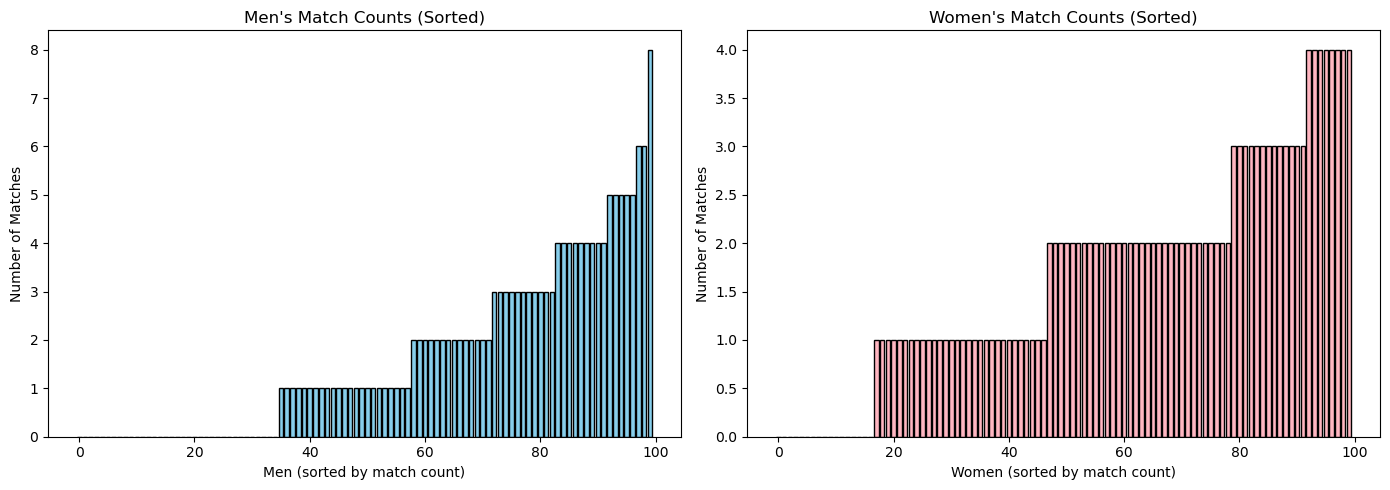

Output()

In [14]:
interactive_hinge_simulation()